# Demand Forecast Model with Random Forest Classifier

In [4]:
from pathlib import Path

import pandas as pd
import numpy as np

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix,accuracy_score
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.tree import export_graphviz #export as dot
from sklearn.preprocessing import StandardScaler


from subprocess import call #convert in png
from IPython.display import Image
import pydot

import itertools

# Data Wrangling

In [5]:
# Data source
data = pd.read_csv(Path.cwd()/'Raw'/'ready-to-train_37w_data.csv', parse_dates=['Datetime'])
data.head()

,Datetime,category,depot_id,return,move,leave,stock
0,2018-09-15,AWP (Aerial work platform),0,0.0,0.0,0.0,0
1,2018-09-16,AWP (Aerial work platform),0,0.0,0.0,0.0,0
2,2018-09-17,AWP (Aerial work platform),0,0.0,0.0,0.0,0
3,2018-09-18,AWP (Aerial work platform),0,0.0,0.0,0.0,0
4,2018-09-19,AWP (Aerial work platform),0,0.0,0.0,0.0,0


In [6]:
len(data)

151920

In [7]:
#data['Month'] = data['Datetime'].dt.month
data['Weekday'] = data['Datetime'].dt.weekday
#data['Quarter'] = data['Datetime'].dt.quarter

df = data.copy()
df = df[(df.stock != 0) & (df.category != 'Other')]
df.head()

,Datetime,category,depot_id,return,move,leave,stock,Weekday
211,2018-09-15,AWP/Articulated boom lift,0,0.0,0.0,0.0,1,5
212,2018-09-16,AWP/Articulated boom lift,0,0.0,0.0,0.0,1,6
213,2018-09-17,AWP/Articulated boom lift,0,0.0,0.0,0.0,1,0
214,2018-09-18,AWP/Articulated boom lift,0,0.0,0.0,0.0,1,1
215,2018-09-19,AWP/Articulated boom lift,0,0.0,0.0,0.0,1,2


In [8]:
len(df)

28649

In [9]:
# Get the average of rentals per category, day and depot
#avg = data.groupby(['Datetime','category','depot_id']).mean().reset_index()
#avg = avg.rename(columns={'leave':'average_leave'})
#data = pd.merge(data, avg[['Datetime','category','depot_id', 'average_leave']], on=['Datetime','category','depot_id'], how='inner')
#data.head()

In [10]:
# Create the feature: are the machine rented Y/N?

df['leave_bool'] = df.leave.astype(bool).astype(int)
#df['stock_bool'] = df.stock.astype(bool).astype(int)

df = df.copy().drop(['return','move','Datetime', 'stock','leave'],axis=1)
df.head()

,category,depot_id,Weekday,leave_bool
211,AWP/Articulated boom lift,0,5,0
212,AWP/Articulated boom lift,0,6,0
213,AWP/Articulated boom lift,0,0,0
214,AWP/Articulated boom lift,0,1,0
215,AWP/Articulated boom lift,0,2,0


## One-hot encoded categorical variables

In [11]:
# Takes categorical variables and converts it to a numerical representation without an arbitrary ordering
df['category'] = pd.get_dummies(df.category)
df.head()

,category,depot_id,Weekday,leave_bool
211,0,0,5,0
212,0,0,6,0
213,0,0,0,0
214,0,0,1,0
215,0,0,2,0


In [12]:
# Other way to do the same
#categ = df.category.unique()
#mymap = dict(zip(categ, range(len(categ))))
#df_test = df_test.applymap(lambda x: mymap.get(x) if x in mymap else x)

In [13]:
# Create a dataset per category hold on a dictionnary

#df_cat = {}

#for cat in df.category.unique():
    #df_cat[cat] = df[df.category == cat]
    #df_cat[cat].reset_index(drop=True, inplace=True)
    #df_cat[cat] = df_cat[cat].drop(['category'],axis=1)
    

## Split labels/features

In [14]:
# Set random seed to ensure reproducible runs
RSEED = 50

# Labels are the values we want to predict: also called target
labels = np.array(df['leave_bool'])

In [15]:
# Remove the labels from the features
features= df.drop(['leave_bool'], axis = 1) #drop leave for the iteration with number predictions
feature_list = list(features.columns)
features = np.array(features)

## Split train/test

During training, we let the model ‘see’ the answers so it can learn how to predict the rentals from the features.

In [16]:
# Splitting 80:20
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, stratify = labels, test_size = 0.2, random_state = RSEED)

In [17]:
train_features.shape

(22919, 3)

In [18]:
test_features.shape

(5730, 3)

In [19]:
train_labels.shape

(22919,)

In [20]:
test_labels.shape

(5730,)

<div class='alert alert-block alert-warning'> There may be extra work involved such as removing outliers, imputing missing values, or converting temporal variables into cyclical representations.
</div>

## Standardisation

In [32]:
scaler = StandardScaler()
train = scaler.fit_transform(train_features)
test = scaler.transform(test_features)

# Random Forest

## 1st Run

In [42]:
# Instantiate model with 100 decision trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               min_samples_split=5,
                               n_jobs=-1, verbose = 1)

# Train the model data on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

Our model has now been trained to learn the relationships between the features and the targets.

In [43]:
# Get the shape of the forest
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 493
Average maximum depth 15


In [44]:
# Figuring out how good the model is
train_predictions = model.predict(train)
predictions = model.predict(test)

train_probs = model.predict_proba(train)[:, 1]
probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


## Evaluate

#### Accuracy

In [45]:
print("Random Forest training accuracy",accuracy_score(train_labels, model.predict(train)))
print("Random Forest test accuracy",accuracy_score(test_labels, model.predict(test)))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Random Forest training accuracy 0.8356821850866094
Random Forest test accuracy 0.8356020942408376


#### Mean Absolute Error (MAE)

non applicable in this case

In [47]:
# Calculate the absolute errors
#errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
#print('Mean Absolute Error:', round(np.mean(errors), 2))

#### ROC

In [37]:
# Plot the ROC curve and get the performance

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.01 Train: 0.01
Precision Baseline: 0.17 Test: 0.67 Train: 0.73
Roc Baseline: 0.5 Test: 0.71 Train: 0.73


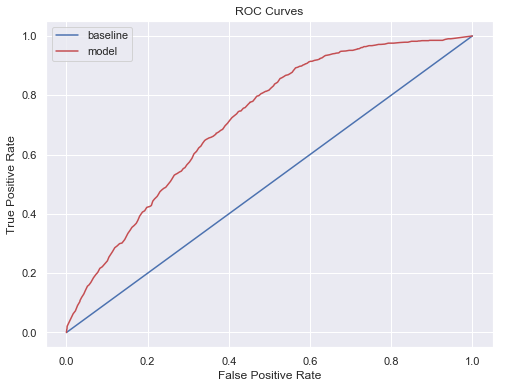

In [38]:
evaluate_model(predictions, probs, train_predictions, train_probs)

#### Confusion matrix

In [39]:
# Plot the confusion matrix

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
        # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[4776    6]
 [ 936   12]]


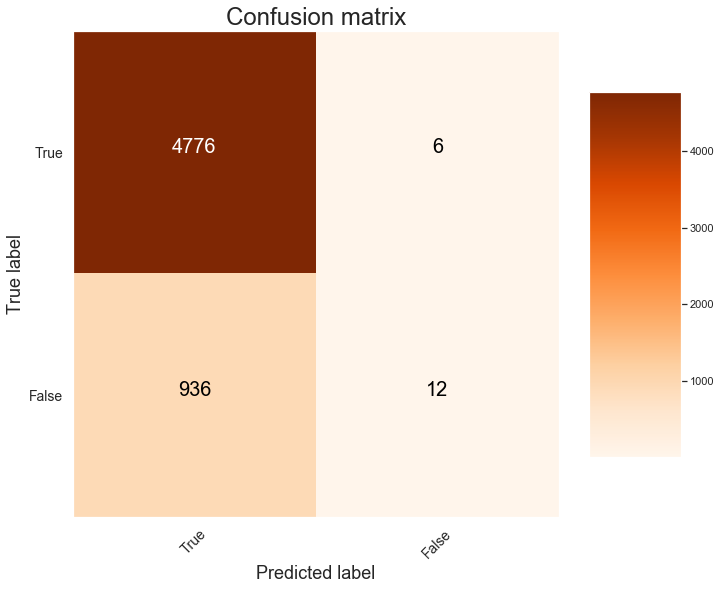

In [40]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['True', 'False'])

In [373]:
# Check the most important features
fi_model = pd.DataFrame({'feature': feature_list,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
2,Weekday,0.585200
1,depot_id,0.385227
0,category,0.029573


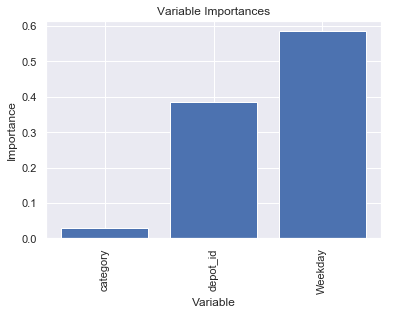

In [375]:
# plotting importance
importance = model.feature_importances_
x_values = list(range(len(importance)))

# Make a bar chart
plt.bar(x_values, importance, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

<div class= 'alert alert-block alert-info'> This is why we should create a dictionnary for each category and apply the model to each category.
</div>

In [379]:
# New random forest with only the two most important variables
model_best_feature = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Extract the two most important features
important_indices = [feature_list.index('Weekday'), feature_list.index('depot_id')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
model_best_feature.fit(train_important, train_labels)

# Figuring out how good the model is
train_predictions_bf = model_best_feature.predict(train_important)
predictions_bf = model_best_feature.predict(test_important)

train_probs_bf = model_best_feature.predict_proba(train_important)[:, 1]
probs_bf = model_best_feature.predict_proba(test_important)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_

Recall Baseline: 1.0 Test: 0.0 Train: 0.0
Precision Baseline: 0.17 Test: 0.0 Train: 0.71
Roc Baseline: 0.5 Test: 0.71 Train: 0.73


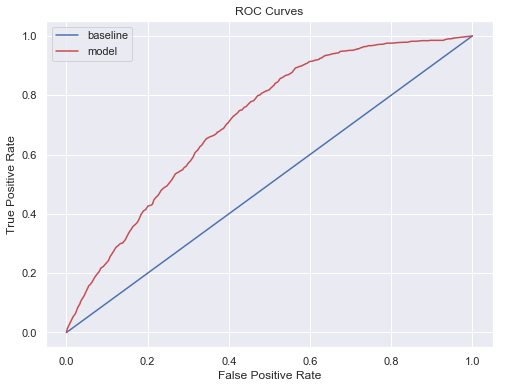

In [380]:
evaluate_model(predictions_bf, probs_bf, train_predictions_bf, train_probs_bf)

## Optimize

### Hyperparameter tuning

In order to maximize the performance of the random forest, we can perform a random search for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values that perform the best. 

In [360]:
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, scoring = 'roc_auc', cv = 3, n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(train_features, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [361]:
rs.best_params_

{'n_estimators': 188,
 'min_samples_split': 2,
 'max_leaf_nodes': 33,
 'max_features': 0.7999999999999999,
 'max_depth': 12,
 'bootstrap': True}

<div class="alert alert-block alert-success"> We can see that the best hyperparameter values are not the defaults. This shows the importance of tuning a model for a specific dataset. Each dataset will have different characteristics, and the model that does best on one dataset will not necessarily do the best across all datasets.
</div>

## Run best model

In [362]:
best_model = rs.best_estimator_

In [363]:
# Predict
train_predictions = best_model.predict(train_features)
predictions = best_model.predict(test_features)

train_probs = best_model.predict_proba(train_features)[:, 1]
probs = best_model.predict_proba(test_features)[:, 1]

In [364]:
# Get the shape of the forest
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 65
Average maximum depth 9


<div class='alert alert-block alert-success'> 
The best maximum depth is not unlimited as we see above! This indicates that restricting the maximum depth of the individual decision trees can improve the cross validation performance of the random forest.

</div>

Recall Baseline: 1.0 Test: 0.01 Train: 0.01
Precision Baseline: 0.17 Test: 0.71 Train: 0.74
Roc Baseline: 0.5 Test: 0.71 Train: 0.72


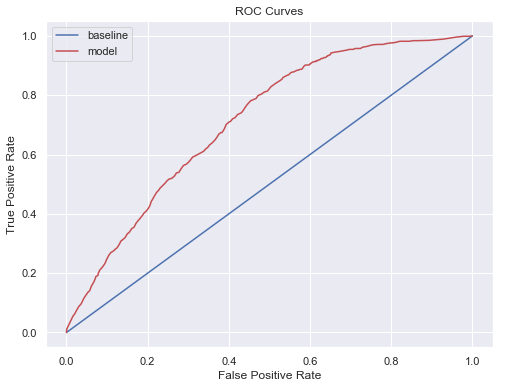

In [365]:
evaluate_model(predictions, probs, train_predictions, train_probs)

<div class='alert alert-block alert-info'> 
The optimized model achieves around the same performance as the default model. More random search iterations could improve performance, or it's possible that we are close the limit of what the random forest can achieve for this problem.
</div>

Confusion matrix, without normalization
[[4777    5]
 [ 936   12]]


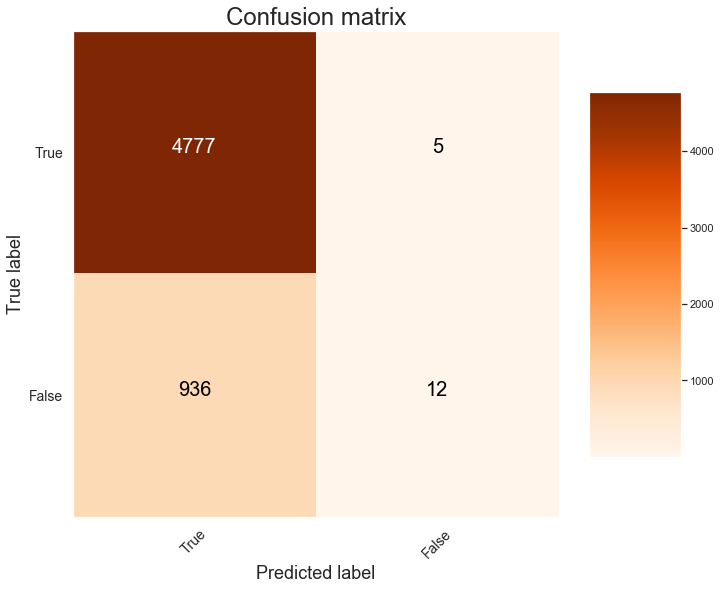

In [366]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['True', 'False'])

## Results

In [78]:
# First iteration
estimator = model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')

FileNotFoundError: [Errno 2] No such file or directory: 'dot': 'dot'

In [118]:
# Best model
estimator = best_model.estimators_[1]


# Export a tree from the forest
dot_data = export_graphviz(estimator, out_file= None,rounded = True, feature_names=train.columns, max_depth = 12, class_names = ['True', 'False'], filled = True)

In [137]:
from sklearn.tree.export import export_text
r = export_text(estimator,feature_names=train.columns.values.tolist())
print(r)

|--- Weekday <= 3.50
|   |--- category <= 13.50
|   |   |--- category <= 4.50
|   |   |   |--- category <= 3.50
|   |   |   |   |--- category <= 0.50
|   |   |   |   |   |--- depot_id <= 40.50
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- depot_id >  40.50
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- category >  0.50
|   |   |   |   |   |--- category <= 1.50
|   |   |   |   |   |   |--- Weekday <= 0.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- Weekday >  0.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- category >  1.50
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |--- category >  3.50
|   |   |   |   |--- depot_id <= 24.50
|   |   |   |   |   |--- depot_id <= 22.50
|   |   |   |   |   |   |--- depot_id <= 21.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- depot_id >  21.50
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- depot_id >  22.50
|  

In [121]:
graph = graphviz.Source(dot_data) 
graph.render("tree") 

PermissionError: [Errno 13] Permission denied: 'dot'

In [122]:
call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])

PermissionError: [Errno 13] Permission denied: 'dot'

In [88]:
Image('tree_from_optimized_forest.png')

TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>